# Specific Heat in Diamond and Lead

We assume to have a material with $3N$ phonon modes, of Einstein frequency $\omega_E$.


## A. System Partition Function

For some solid of N atoms there will be 3N normal modes. Each normal mode, which can be represented classically as a wave of distortion in the lattice of the material, gives rise to a quantum of sound- a phonon of characteristic frequency $\omega_i$ and energy $\hbar \omega_i$. The quantum state of a solid (at low enough temperatures) can be modelled as a volume containing a gas of non-interacting phonons. The partition function for a mode:

$\displaystyle Q_N (V, T) = \sum_n e^{-\beta E_n}$.


For some state which has $n_i$ phonons of type i (i.e. of characteristic frequency $\omega_i$), the total energy of the state is:

$\displaystyle E\{n_i\} = \sum_{i=1}^{3N}n_i \hbar \omega_i$,

and so:

$\displaystyle Q_N (V, T) = \sum_{i=1}^{3N} e^{-\beta E_i}$.


Since we assume that $N \to \infty$, and using the **important assumption** that for an Einstein model all characteristic frequencies are taken to be equal, we can evaluate the expression with an infinite-term geometric progression to obtain:

$Q_N (V, T) = \frac{1}{1 - \exp({-\beta \hbar\omega_E})}$.

Since we assumed that the phonons are independent, the full partition function can be written as a product of the partition functions of nodes:

$\displaystyle Q = \prod^{3N}_{i = 1} Q_N = Q_N^{3N}$.

Therefore, the partition function for such a system is:

$\text{Q} = \prod\limits^{3N}_{i = 1} \frac{1}{1 - \exp(-\beta\hbar\omega_E)}$.



## B. Average Phonon Occupation Levels

The probability of finding n phonons is:

$\displaystyle P_n = \frac{e^{-\beta E_n}}{\sum^{\infty}_{n=0}e^{-\beta E_n}}$,

where the denominator is $Q_N^{-1}$. The average occupation state is then simply the sum of this the probability of finding n phonons times the number of phonons:

$\displaystyle <n> = \sum^{\infty}_{n=0} P_n \cdot n = 1 - e^{-\beta \hbar \omega_E} \cdot \sum^{\infty}_{n=0}ne^{-\beta \hbar\omega_E n} = 1 - e^{-\beta \hbar \omega_E} \cdot \frac{e^{-\beta \hbar \omega_E}}{(1 - e^{-\beta \hbar \omega_E})^2} = \frac{1}{e^{\beta\hbar\omega_E}-1}$

## C. System Total Energy

Average energy can be computed by summing the average phonon occupation times the respective energy per mode:

$\displaystyle U = \sum^{3N}_{i=1} \hbar \omega_i <n_i> \ = \sum^{3N}_{i=1} \frac{\hbar \omega_E}{e^{\beta \hbar \omega_E} - 1}$

OR:

$\ln Q = - 3N \cdot \ln(1 - e^{-\beta \hbar \omega_E})$

$U = - \frac{\partial \ln Q}{\partial \beta} = 3N \frac{1}{1 - e^{-\beta \hbar \omega_E}} \cdot \hbar \omega_E e^{-\beta \hbar \omega_E} = 3N \frac{\hbar \omega_E}{e^{\beta \hbar \omega_E} - 1}$

which both give the same result!

## D. System Heat Capacity ($C_V$)

Heat capacity is the change in energy with respect to temperature. For a solid:

$C_V \approx C_p = C = \frac{\partial U}{\partial T}$

Since $\beta = \frac{1}{k_B T}$:

$C_V = 3N\hbar \omega_E \left( -\frac{\hbar \omega_E}{k_B} (-1) \frac{1}{T^2} \frac{e^{\beta \hbar \omega_E}}{(e^{\beta \hbar \omega_E -1})^{2}} \right) = 3N \hbar^2 \omega_E^2 \beta^2 k_B \left( \frac{e^{\beta \hbar \omega_E}}{(e^{\beta \hbar \omega_E} - 1)^2}\right)$



In [1]:
# Imports

import numpy as np
import scipy as sp
import requests
import pandas as pd
from io import StringIO
import pint #I shall certainly be importing a pint after this assignment is done :)
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# !pip install pint

In [2]:
# Data Processing & Misc. for even smoother sailing?
## specific hear diamond data was given in cal/mol/K
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

In [3]:
k_B = Q_(1.380649e-23, 'joule / kelvin')
hbar = Q_(1.0545718e-34, 'joule * second') 
N_A = Q_(6.02214076e23, '1 / mole') 
room_T = Q_(294, 'kelvin')

In [4]:
# Data Gathering for smooth sailing

diamond_url = 'https://raw.githubusercontent.com/diodeamy/StatMech/refs/heads/main/data/diamond.dat'
lead_url = 'https://raw.githubusercontent.com/diodeamy/StatMech/refs/heads/main/data/lead.dat'

diamond_resp = requests.get(diamond_url)
diamond_str = diamond_resp.text
diamond_io = StringIO(diamond_str)
diamond_df = pd.read_csv(diamond_io, comment='#', header=None, delim_whitespace=True)

lead_resp = requests.get(lead_url)
lead_str = lead_resp.text
lead_io = StringIO(lead_str)
lead_df = pd.read_csv(lead_io, header=None, delim_whitespace=True)


In [5]:
diamond_df.columns = ['Temperature', 'Specific_Heat']
lead_df.columns = ['Temperature', 'Specific_Heat']


###############

### please run the commented code in this section once to convert the specific heat capacity units, otherwise all results will be bogus. 

diamond_df['Specific_Heat'] = Q_(diamond_df['Specific_Heat'].values, 'calorie / mole / kelvin').to('joule / mole / kelvin').magnitude
diamond_df['Temperature'] = Q_(diamond_df['Temperature'].values, 'kelvin').magnitude

### after plotting the fits to the data I realised that the lead specific heat was already given in joules, so no need to convert

###############

# print(diamond_df)

ts_diamond = diamond_df['Temperature'].values
shs_diamond = diamond_df['Specific_Heat'].values

# print(shs_diamond)
ts_lead = lead_df['Temperature'].values
shs_lead = lead_df['Specific_Heat'].values



In [6]:
def einstein_CV(T, T_E):
    T = Q_(T, 'kelvin')
    T_E = Q_(T_E, 'kelvin')
    x = T_E/T
    exp_term = np.exp(-x.magnitude)
    C_V = 3 * N_A * k_B * x ** 2 * (exp_term/ (exp_term - 1) ** 2)

    return C_V.magnitude

## E. Diamond Einstein Temperature ($T_E$) (by fit)

In this section we look at the datafile for measurements of the specific heat of diamond in order to obtain the Einstein temperature of the system by fitting. 

In [7]:
poptE_diamond, _ = curve_fit(einstein_CV, ts_diamond, shs_diamond, p0=[10])
T_E_fit_diamond = poptE_diamond[0]
print(f"Fitted Einstein temperature: {T_E_fit_diamond:.2f} K")

Fitted Einstein temperature: 1363.75 K


## F. Diamond Debye Temperature ($T_D$) (by fit)

We wish to find the Debye temperature of diamond, by fitting the Debye model to the measurements of specific heat. We use a formulation such that the solution is more stable for small values of temperature. 

In [8]:
def debye_CV(T, T_D):

    CVs = []
    T = Q_(T, 'kelvin')
    T_D = Q_(T_D, 'kelvin')

    for temp in T:
        x_D = (T_D/temp)

        if x_D > 40:
            C_V = N_A * k_B * (12 * np.pi**2 / 5) * (1/x_D) ** 3

        elif x_D < 0.1:
            C_V = 3 * N_A * k_B * (1 - (1/20) * x_D **2)

        else:
            def integral(x):
                return (x**4 * np.exp(-x)) / (1 - np.exp(-x))**2 
            
            result, _ = quad(integral, 0, x_D)
            C_V = 9 * N_A * k_B * (1/x_D)**3 * result
        
        CVs.append(C_V.magnitude)

    return np.array(CVs)    

In [9]:
poptD_diamond, _ = curve_fit(debye_CV, ts_diamond, shs_diamond, p0 = [1000])

T_D_fit_diamond = poptD_diamond[0]
print(f"Fitted Debye temperature : {T_D_fit_diamond:.2f} K")

Fitted Debye temperature : 1853.73 K


## G. Debye Model vs. Einstein Model Comparison (for diamond)

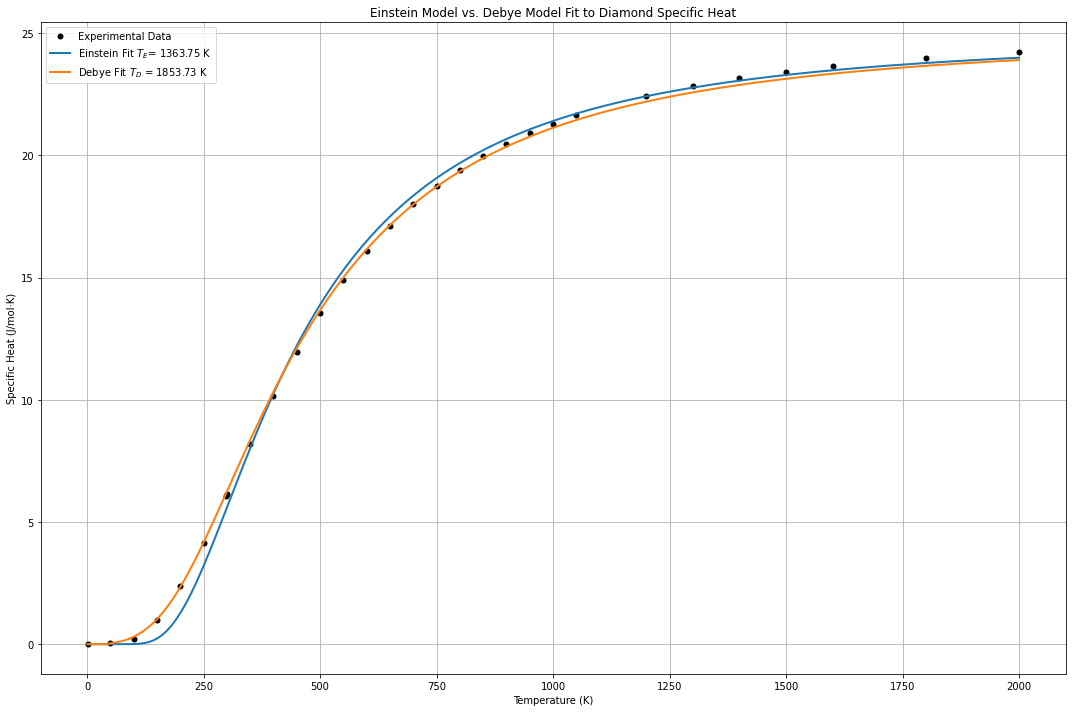

In [10]:
T_fit_diamond = np.linspace(min(ts_diamond), max(ts_diamond), 300)
Einstein_fit_diamond = einstein_CV(T_fit_diamond, T_E_fit_diamond)
Debye_fit_diamond = debye_CV(T_fit_diamond, T_D_fit_diamond)

plt.figure(figsize=(15, 10))
plt.plot(ts_diamond, shs_diamond, 'o', label='Experimental Data', markersize=5, color='black')
plt.plot(T_fit_diamond, Einstein_fit_diamond, '-', label=f'Einstein Fit $T_E$= {T_E_fit_diamond:.2f} K', linewidth=2)
plt.plot(T_fit_diamond, Debye_fit_diamond, '-', label=f'Debye Fit $T_D$ = {T_D_fit_diamond:.2f} K', linewidth=2)
plt.xlabel('Temperature (K)')
plt.ylabel('Specific Heat (J/mol·K)')
# plt.xscale('log')
plt.title('Einstein Model vs. Debye Model Fit to Diamond Specific Heat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
## I don't really trust my eyes that much so:

# residuals method:
fit_E_diamond = einstein_CV(ts_diamond, T_E_fit_diamond)
fit_D_diamond = debye_CV(ts_diamond, T_D_fit_diamond)

resid_E_diamond = np.sum((shs_diamond - fit_E_diamond) ** 2)
resid_D_diamond = np.sum((shs_diamond - fit_D_diamond) ** 2)

print(f"The residual sum of squares for Einstein fit is {resid_E_diamond:.2f} K and for Debye fit is: {resid_D_diamond:.2f} K")

r2_E = r2_score(shs_diamond,fit_E_diamond )
r2_D = r2_score(shs_diamond, fit_D_diamond)

print(f" The R2 for Einstein fit is: {r2_E:.6f} and for the Debye fit is: {r2_D:.6f} ")

The residual sum of squares for Einstein fit is 4.68 K and for Debye fit is: 0.80 K
 The R2 for Einstein fit is: 0.997759 and for the Debye fit is: 0.999615 


Both models do pretty well visually. It seems that the Einstein model does somewhat better in the high temperatures and the Debye does better in the low temperatures. Based on the above metrics, the Debye model performs better.

## H. Debye Model vs. Einstein Model Comparison (for lead)

### H.a. Einstein Temperature ($T_E$) (by fit) - lead

In [12]:
poptE_lead, _ = curve_fit(einstein_CV, ts_lead, shs_lead, p0=[50])
T_E_fit_lead = poptE_lead[0]
print(f"Fitted Einstein temperature: {T_E_fit_lead:.2f} K")

Fitted Einstein temperature: 66.27 K


### H.b. Debye Temperature ($T_D$) (by fit) - lead

In [13]:
poptD_lead, _ = curve_fit(debye_CV, ts_lead, shs_lead, p0 = [50])

T_D_fit_lead = poptD_lead[0]
print(f"Fitted Debye temperature : {T_D_fit_lead:.2f} K")

Fitted Debye temperature : 89.22 K


### H.c. Model Comparison - lead

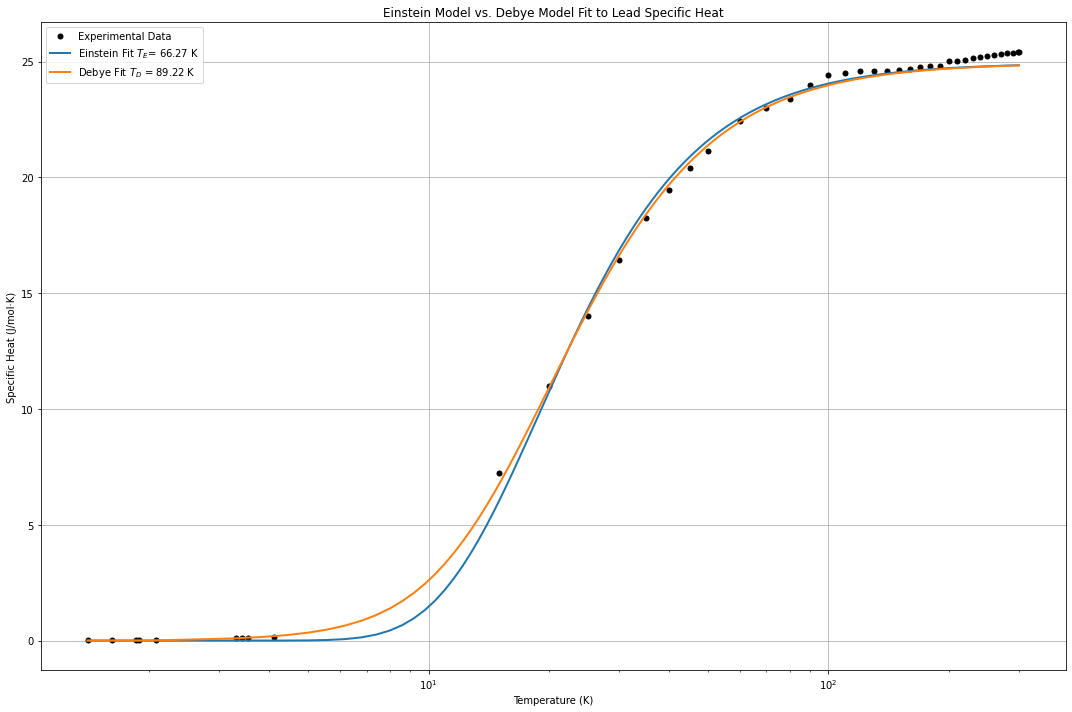

In [14]:
T_fit_lead = np.linspace(min(ts_lead), max(ts_lead), 500)
Einstein_fit_lead = einstein_CV(T_fit_lead, T_E_fit_lead)
Debye_fit_lead = debye_CV(T_fit_lead, T_D_fit_lead)

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(ts_lead, shs_lead, 'o', label='Experimental Data', markersize=5, color='black')
plt.plot(T_fit_lead, Einstein_fit_lead, '-', label=f'Einstein Fit $T_E$= {T_E_fit_lead:.2f} K', linewidth=2)
plt.plot(T_fit_lead, Debye_fit_lead, '-', label=f'Debye Fit $T_D$ = {T_D_fit_lead:.2f} K', linewidth=2)
plt.xlabel('Temperature (K)')
plt.ylabel('Specific Heat (J/mol·K)')
plt.xscale('log')
plt.title('Einstein Model vs. Debye Model Fit to Lead Specific Heat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

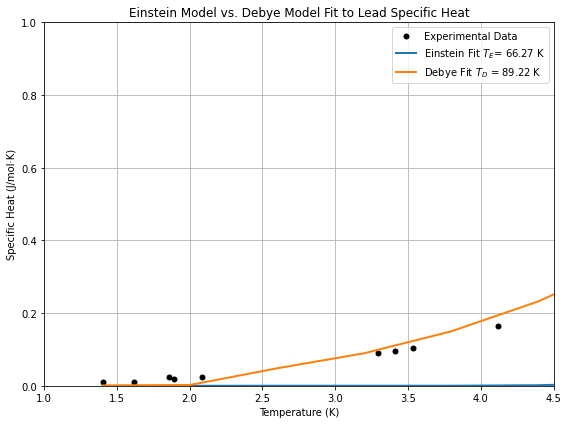

In [15]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(ts_lead, shs_lead, 'o', label='Experimental Data', markersize=5, color='black')
plt.plot(T_fit_lead, Einstein_fit_lead, '-', label=f'Einstein Fit $T_E$= {T_E_fit_lead:.2f} K', linewidth=2)
plt.plot(T_fit_lead, Debye_fit_lead, '-', label=f'Debye Fit $T_D$ = {T_D_fit_lead:.2f} K', linewidth=2)
plt.xlabel('Temperature (K)')
plt.ylabel('Specific Heat (J/mol·K)')
plt.xlim(1, 4.5)
plt.ylim(0,1 )
# plt.xscale('log')
plt.title('Einstein Model vs. Debye Model Fit to Lead Specific Heat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
## I don't really trust my eyes that much so:

# residuals method:
fit_E_lead = einstein_CV(ts_lead, T_E_fit_lead)
fit_D_lead = debye_CV(ts_lead, T_D_fit_lead)

resid_E_lead = np.sum((shs_lead - fit_E_lead) ** 2)
resid_D_lead = np.sum((shs_lead - fit_D_lead) ** 2)

print(f"The residual sum of squares for Einstein fit is {resid_E_lead:.2f} K and for Debye fit is: {resid_D_lead:.2f} K")

r2_E_lead = r2_score(shs_lead,fit_E_lead )
r2_D_lead = r2_score(shs_lead, fit_D_lead)

print(f" The R2 for Einstein fit is: {r2_E_lead:.6f} and for the Debye fit is: {r2_D_lead:.6f} ")

The residual sum of squares for Einstein fit is 5.64 K and for Debye fit is: 3.75 K
 The R2 for Einstein fit is: 0.998682 and for the Debye fit is: 0.999123 


## I. Diamond vs. Lead Comparison Discussion

The quality of fit is slightly worse for both models when applying them to lead, as compared to diamond. I think this is because there is a conglomeration of data-points at low temperatures, so the models have a hard time accounting for quantum effects that may be making themselves felt in this range, especially the Einstein one.

## J. Fermi Temperature ($T_F$) (by fit) - lead

In [17]:
def fermi_CV(T, T_F):
    T = Q_(T, 'kelvin')
    T_F = Q_(T_F, 'kelvin')
    x = (T_F/T)

    C_V = N_A * k_B *(np.pi ** 2/2) * (1/x)

    return C_V.magnitude

In [ ]:
poptF_lead, _ = curve_fit(fermi_CV, ts_lead, shs_lead, p0 = [100])

T_F_fit_lead = poptF_lead[0]
print(f"Fitted Fermi temperature : {T_F_fit_lead:.2f} K")

Fitted Debye temperature : 342.82 K


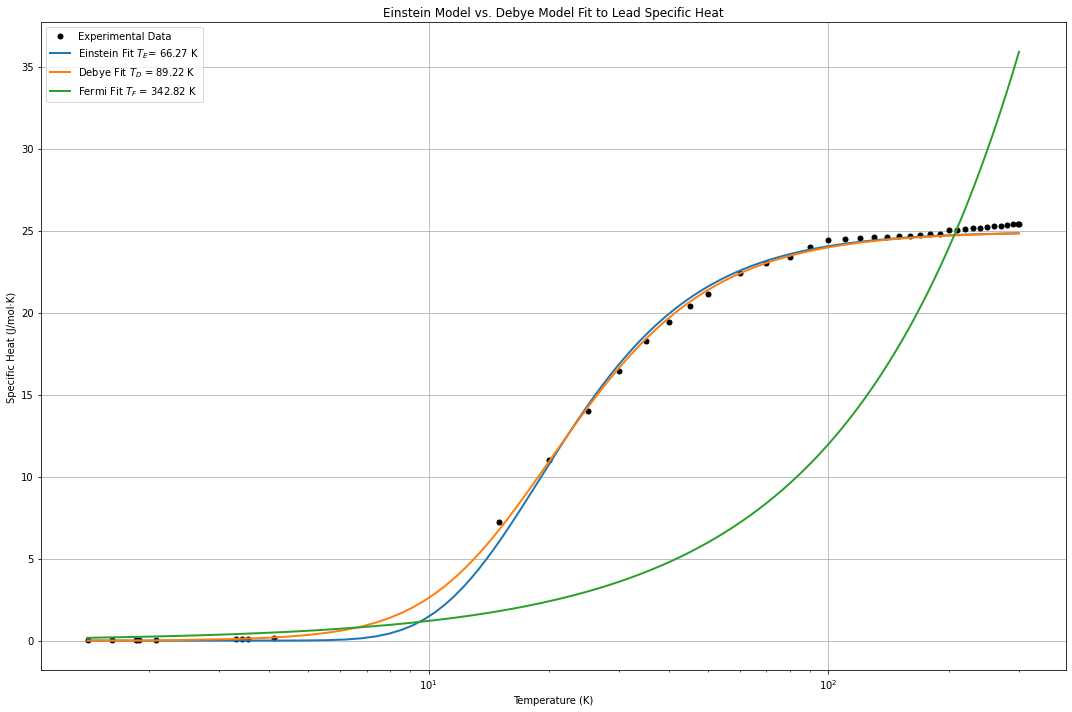

In [ ]:
T_fit_lead = np.linspace(min(ts_lead), max(ts_lead), 500)
Fermi_fit_lead = fermi_CV(T_fit_lead, T_F_fit_lead)
Einstein_fit_lead = einstein_CV(T_fit_lead, T_E_fit_lead)
Debye_fit_lead = debye_CV(T_fit_lead, T_D_fit_lead)

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(ts_lead, shs_lead, 'o', label='Experimental Data', markersize=5, color='black')
plt.plot(T_fit_lead, Einstein_fit_lead, '-', label=f'Einstein Fit $T_E$= {T_E_fit_lead:.2f} K', linewidth=2)
plt.plot(T_fit_lead, Debye_fit_lead, '-', label=f'Debye Fit $T_D$ = {T_D_fit_lead:.2f} K', linewidth=2)
plt.plot(T_fit_lead, Fermi_fit_lead, '-', label=f'Fermi Fit $T_F$ = {T_F_fit_lead:.2f} K', linewidth=2)
plt.xlabel('Temperature (K)')
plt.ylabel('Specific Heat (J/mol·K)')
plt.xscale('log')
plt.title('Einstein Model vs. Debye Model vs. Fermi Model Fit to Lead Specific Heat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The above looks like trash so I will do a terrible thing that should never ever be done in science and fit on a very small amount of data-points:

Fitted Fermi temperature : 3926.39 K
Fitted Debye temperature : 83.48 K
Fitted Enistein temperature : 24.00 K


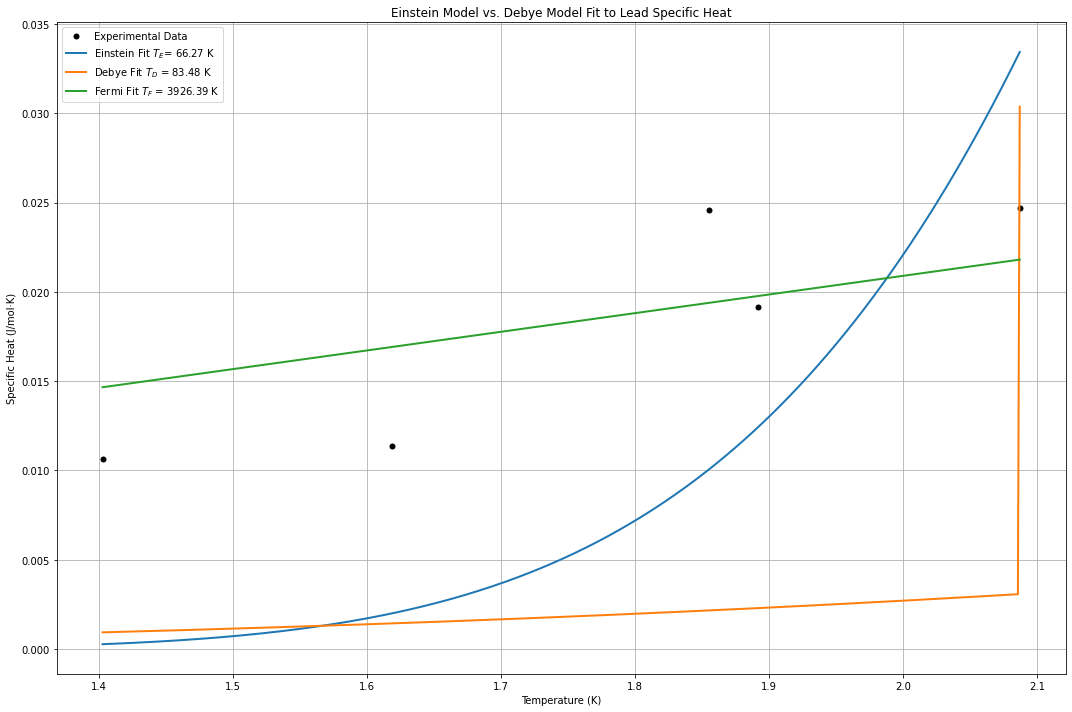

In [ ]:
n =5

poptF_lead_s, _ = curve_fit(fermi_CV, ts_lead[:n], shs_lead[:n], p0 = [100])

T_F_fit_lead_s = poptF_lead_s[0]
print(f"Fitted Fermi temperature : {T_F_fit_lead_s:.2f} K")



poptD_lead_s, _ = curve_fit(debye_CV, ts_lead[:n], shs_lead[:n], p0 = [100])

T_D_fit_lead_s = poptD_lead_s[0]
print(f"Fitted Debye temperature : {T_D_fit_lead_s:.2f} K")



poptE_lead_s, _ = curve_fit(einstein_CV, ts_lead[:n], shs_lead[:n], p0 = [10])

T_E_fit_lead_s = poptE_lead_s[0]
print(f"Fitted Enistein temperature : {T_E_fit_lead_s:.2f} K")


T_fit_lead = np.linspace(min(ts_lead[:n]), max(ts_lead[:n]), 500)
Fermi_fit_lead_s = fermi_CV(T_fit_lead, T_F_fit_lead_s)
Einstein_fit_lead_s = einstein_CV(T_fit_lead, T_E_fit_lead_s)
Debye_fit_lead_s = debye_CV(T_fit_lead, T_D_fit_lead_s)

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(ts_lead[:n], shs_lead[:n], 'o', label='Experimental Data', markersize=5, color='black')
plt.plot(T_fit_lead, Einstein_fit_lead_s, '-', label=f'Einstein Fit $T_E$= {T_E_fit_lead:.2f} K', linewidth=2)
plt.plot(T_fit_lead, Debye_fit_lead_s, '-', label=f'Debye Fit $T_D$ = {T_D_fit_lead_s:.2f} K', linewidth=2)
plt.plot(T_fit_lead, Fermi_fit_lead_s, '-', label=f'Fermi Fit $T_F$ = {T_F_fit_lead_s:.2f} K', linewidth=2)
plt.xlabel('Temperature (K)')
plt.ylabel('Specific Heat (J/mol·K)')
# plt.xscale('log')
plt.title('Einstein Model vs. Debye Model vs. Fermi Model Fit to Lead Specific Heat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Looks like now the Fermi fit is better indeed.

## K. Room-Temperature Entropy by Debye Function - diamond & lead

In [21]:
def let_it_be_entropy(T, C_V):
    T = Q_(T, 'kelvin')
    C_V = Q_(C_V, 'joule / mole / kelvin')
    
    def entropy(x):
        return  C_V/x
            
    result, _ = quad(entropy, min(T), max(T))

    return result

In [22]:
from scipy.integrate import simpson

diamond_mask  = ts_diamond <= 300

S_lead = simpson(y = fit_D_lead / ts_lead, x =ts_lead)
S_diamond = simpson(y = fit_D_diamond[diamond_mask] / ts_diamond[diamond_mask],x= ts_diamond[diamond_mask])

print(f"lead entropy at room temp is {S_lead:.2f} and diamond entropy is {S_diamond:.2f}")

lead entropy at room temp is 63.83 and diamond entropy is 2.45
